In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

In [2]:
from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 54 results
transitions_data returned 204 results
total_population_data returned 18 results
initialization time:  7.308393955230713
simulation_time:  0.736609935760498
initialization time:  7.667863130569458
simulation_time:  0.6759548187255859
initialization time:  6.937812328338623
simulation_time:  0.7708277702331543


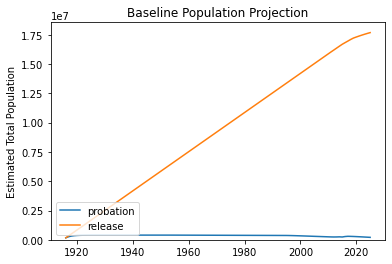

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/CA/CA_probation_model_inputs.yaml')
test_sim.simulate_baseline(['probation', 'release'])

In [4]:
outflows_data, transitions_data = test_sim.data_dict['outflows_data'], test_sim.data_dict['transitions_data']
outflows_data.iloc[20:30][['compartment', 'crime_type', 'outflow_to', 'total_population', 'time_step']]

,compartment,crime_type,outflow_to,total_population,time_step
224,probation,felony,prison,54126.0,-3.0
225,probation,felony,prison,53060.0,-2.0
226,probation,felony,prison,46226.0,-1.0
227,probation,felony,prison,39804.0,0.0
228,probation,felony,prison,38759.0,1.0
229,probation,felony,prison,35757.0,2.0
230,probation,felony,prison,37763.0,3.0
231,prison_shell,misdemeanor,probation,29061.0,-5.0
232,prison_shell,misdemeanor,probation,28311.0,-4.0
233,prison_shell,misdemeanor,probation,28611.0,-3.0


initialization time:  0.007055997848510742
simulation_time:  1.8132047653198242
initialization time:  0.003945112228393555
simulation_time:  1.7047569751739502


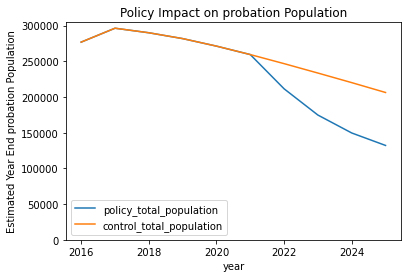

In [4]:
supervision_period_reductions = {'felony': .6, 'misdemeanor': 2 / 3}

def apply_reduced_probation_cap(crime_type, retroactive=True):
    return partial(IncarceratedTransitions.apply_supervision_cap_reduction, 
                   supervision_period_reduction=supervision_period_reductions[crime_type], retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap('felony', False),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=False),
    SparkPolicy(policy_fn=apply_reduced_probation_cap('misdemeanor', False),
                spark_compartment='probation',
                sub_population={'crime_type': 'misdemeanor'},
                apply_retroactive=False)
]

policy_list_retroactive = [
    SparkPolicy(policy_fn=apply_reduced_probation_cap('felony'),
                spark_compartment='probation',
                sub_population={'crime_type': 'felony'},
                apply_retroactive=True),
    SparkPolicy(policy_fn=apply_reduced_probation_cap('misdemeanor'),
                spark_compartment='probation',
                sub_population={'crime_type': 'misdemeanor'},
                apply_retroactive=True)
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

initialization time:  0.003526926040649414


/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:672: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:6

simulation_time:  1.7132041454315186
initialization time:  0.0025739669799804688
simulation_time:  1.8317468166351318
initialization time:  0.0021839141845703125
simulation_time:  1.6649129390716553
initialization time:  0.002215862274169922
simulation_time:  1.6351442337036133
initialization time:  0.00238800048828125
simulation_time:  1.615818977355957


,felony,misdemeanor
6,13.895469,17.672272
7,13.430037,29.275032
8,18.082925,26.623404
9,20.222226,27.098601
10,20.222226,27.098601


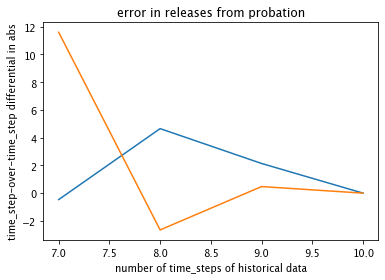

In [6]:
test_sim.calculate_outflows_data_sparsity_error('probation', 'release', (6,11))

In [7]:
test_sim.pop_simulations['with_10_time_steps_of_historical_data'].sub_simulations['felony'].get_error('probation')

outflow_to,prison,release
time_step,,
-5.0,-16.910330,-22.830756
-4.0,-18.221823,-22.120868
-3.0,-29.362745,-27.411080
-2.0,-26.509137,-25.954036
-1.0,-15.246648,-15.785371
0.0,-9.788343,-10.830899
1.0,-14.464502,-15.770329
2.0,-11.745100,-20.997949
3.0,-23.011897,-20.298743


In [8]:
test_results

,compartment,year,policy_total_population,control_total_population
0,prison,2016.0,1.009733e+06,1.009733e+06
1,prison,2017.0,1.062208e+06,1.062208e+06
2,prison,2018.0,1.108692e+06,1.108692e+06
3,prison,2019.0,1.156584e+06,1.156584e+06
4,prison,2020.0,1.191849e+06,1.191849e+06
5,prison,2021.0,1.225056e+06,1.225056e+06
6,prison,2022.0,1.249835e+06,1.256527e+06
7,prison,2023.0,1.269558e+06,1.286254e+06
8,prison,2024.0,1.285891e+06,1.314125e+06
9,prison,2025.0,1.299997e+06,1.340305e+06


In [9]:
prison_results = test_results[test_results['compartment'] == 'prison']
prison_results.index = prison_results['year']
prison_results['control_total_population'] - prison_results['policy_total_population']

year
2016.0        0.000000
2017.0        0.000000
2018.0        0.000000
2019.0        0.000000
2020.0        0.000000
2021.0        0.000000
2022.0     6692.840042
2023.0    16696.286723
2024.0    28234.684408
2025.0    40308.147848
dtype: float64

In [10]:
probation_results = test_results[test_results['compartment'] == 'probation']
probation_results.index = prison_results['year']
probation_results

,compartment,year,policy_total_population,control_total_population
year,,,,
2016.0,probation,2016.0,363987.964097,363987.964097
2017.0,probation,2017.0,346996.484816,346996.484816
2018.0,probation,2018.0,319431.223680,319431.223680
2019.0,probation,2019.0,298791.153290,298791.153290
2020.0,probation,2020.0,280898.479918,280898.479918
2021.0,probation,2021.0,264694.261817,264694.261817
2022.0,probation,2022.0,214071.649900,249298.916852
2023.0,probation,2023.0,175667.681107,234512.355692
2024.0,probation,2024.0,149812.063666,220341.133452
